# Ranking Modelleri

## Ranking Nedir? 

Ranking, en alakalı/ilgili olanı en üste getirme sanatıdır.

Örnekler: Recommendation, Ads, Search, Propensity...

## Ranking vs. Classification & Regression

| Özellik       | Regression                              | Classification                       | Ranking                                                            |
|---------------|-----------------------------------------|--------------------------------------|--------------------------------------------------------------------|
|Amaç           |Gerçek bir değer tahmini (Örn: Ev fiyatı)|Sınıf tahmini (Örn: Spam mi değil mi?)|Sıralama / Düzen (Örn: A, B'den daha mı alakalı?)                   |
|Çıktı          |y∈R (Sürekli sayı)                       |y∈{0,1} (Sınıf etiketi)               |Permütasyon / Liste                                                 |
|Başarı Kriteri |Hata (MSE, MAE vs.) düşüklüğü            |Doğruluk (Accuracy, AUC, F1 vs.)      |Listenin başındaki kalite (NDCG, MRR)                               |
|Bağımsızlık    |Veriler genelde birbirinden bağımsızdır. |Veriler bağımsızdır.                  |Veriler gruplar (query/user) halindedir ve birbirleriyle yarışırlar.|

Farklar:
- Amaç: 
    - Regression: Gerçek değer tahmini
    - Classification: Sınıf tahmini
    - Ranking: Sıralama/Düzen
- Optimization kriteri farklı
- Evaluation metrikleri farklı (NDCG, MRR vs Accuracy)
- Regressinon ve Classification'da veriler genelde birbirinden bağımsızdır fakat ranking de veriler gruplar (query/user) halindedir ve birbirleriyle yarışırla

## Global vs. Contextual Ranking

Global Ranking: Tüm objeler için sabitlenen bir sıra
    
Contextual Ranking: Query/Kullanıcı/Bağlama göre değişen sıra

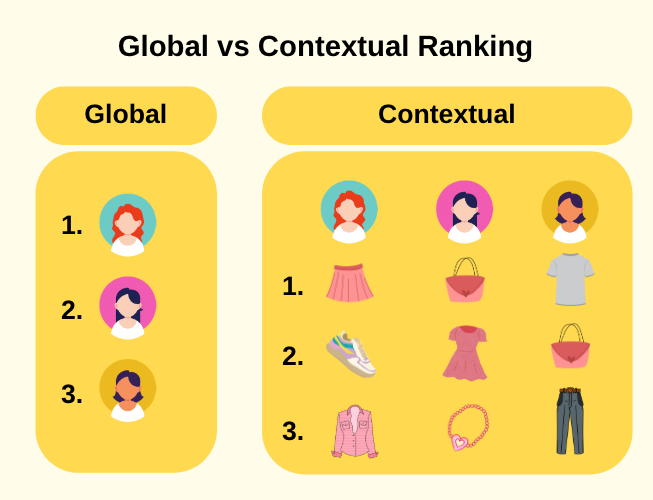

## Learning to Rank (LTR) Yaklaşımları

POINTWISE (En Basit)
- Tanım: Her item'i birbirinden bağımsız olarak score'lamak
- Örnek: "Bu film 4.5 yıldız, bu 3 yıldız"
- Model: Classification/Regression (her item ayrı tahmin)
- Problem: İtem'ler arasındaki SIRA bilgisini kullanmıyor

PAIRWISE (Orta Seviye)
- Tanım: İki item'i kıyaslayarak "hangisi daha iyi?" sorusu
- Örnek: "Film A, Film B'den daha iyi" (1 etiket)
- Model: Preference learning (RankNet, LambdaMART)
- Avantaj: Sıra bilgisini öğreniyor

LISTWISE (En Gelişmiş)
- Tanım: Tüm list'i birden sıralaması gereken liste
- Örnek: "Google query için en iyi 10 sonuç" (sıralı liste)
- Model: LambdaMART, ListNet, Direct ranking models
- Avantaj: Tüm sıra bilgisini top-to-bottom kullanıyor

## Gerekli Kütüphaneler

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import scipy.stats as stats
import warnings
import math

In [66]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, ndcg_score

## Problem 1: Bank Marketing (Global Ranking)

Bank Marketing verisi, Portekiz’de bir bankanın telefon kampanyası sonuçlarını içeriyor. Amaç müşterinin mevduat (term deposit) açıp açmayacağını tahmin etmek.

https://archive.ics.uci.edu/datasets

In [4]:
df_bank = pd.read_csv('bank-additional-full.csv', sep=';')

In [103]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [104]:
X = df_bank.drop("y", axis = 1)
y = df_bank.y

In [105]:
categoric_cols = X.select_dtypes(include='object').columns.tolist()

In [106]:
categoric_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [107]:
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [11]:
for col in categoric_cols:
    print(f"{col}: {df_bank[col].unique()}")

In [12]:
for c in categoric_cols:
    X[c] = X[c].astype("category")

In [13]:
y = y.replace({"yes": 1, "no": 0})

In [14]:
np.sum(y == 1) / len(y)

0.11265417111780131

### Modelling

#### AUC (ROC AUC — Area Under the ROC Curve):
    
Ayırt Etme Gücü: Modelin pozitif ve negatif sınıfları birbirinden ne kadar iyi ayrıştırdığının ölçüsüdür. (Baz değer 0.5, yani rastgele tahmindir).

Threshold Bağımsızlığı: Accuracy veya F1 Score gibi metriklerin aksine, belirli bir eşik değerine (threshold) ihtiyaç duymaz.

Sıralama (Ranking) Odaklı: Modelin ürettiği olasılık değerlerinin mutlak büyüklüğüne değil, sıralamasına bakar. Pozitif örneğe negatiften daha yüksek puan verip vermediğini ölçer.

Kullanım Alanı: Özellikle dengesiz veri setlerinde ve en uygun threshold değerinin henüz belirlenmediği aşamalarda modelin genel performansını görmek için idealdir.

#### Precision @ k, Recall @ k, Lift @ k:

Precision @ k (İlk k'da Kesinlik): Modelin en yüksek skorla önerdiği ilk k sonucun (örn. ilk 10 ürün) ne kadarının isabetli olduğunu gösterir. Kullanıcının önüne düşen listenin "ne kadar temiz ve doğru" olduğuyla ilgilenir.

Recall @ k (İlk k'da Kapsama): Veri setinde var olan tüm pozitif/ilgili öğelerin ne kadarının, modelin sunduğu ilk k sonuç arasına girebildiğini ölçer. Sistemin, kullanıcının ilgisini çekebilecek tüm seçenekleri listenin en başına taşıyıp taşıyamadığını gösterir.

Lift @ k (İlk k'da Kaldıraç): Modelin seçtiği ilk k gruptaki başarı oranının, veri setindeki genel ortalamaya (rastgele seçime) göre kaç kat daha yüksek olduğunu ifade eder. Modelin, en değerli örnekleri listenin en tepesine yığma (ranking) becerisini kanıtlar.

In [16]:
def precision_recall_lift_at_k(y_true, y_score, percentage=0.1):

    y_true = np.array(y_true)
    y_score = np.array(y_score)
    
    n = len(y_true)
    k = int(n * percentage)
    
    idx = np.argsort(-y_score)
    topk_idx = idx[:k]
    
    # precision@k
    precision_at_k = y_true[topk_idx].sum() / k
    
    # recall@k
    recall_at_k = y_true[topk_idx].sum() / y_true.sum()
    
    # base rate
    base_rate = y_true.mean()
    
    # lift@k
    lift_at_k = precision_at_k / base_rate if base_rate > 0 else np.nan
    
    return {
        "precision_at_k": round(precision_at_k, 3),
        "recall_at_k": round(recall_at_k, 3),
        "lift_at_k": round(lift_at_k, 3)
    }

### Cross Validation

Cross Validation (Çapraz Doğrulama), modelin performansını ölçerken "şans faktörünü" ortadan kaldırmak için kullanılan bir yöntemdir.

#### Time Series Split:

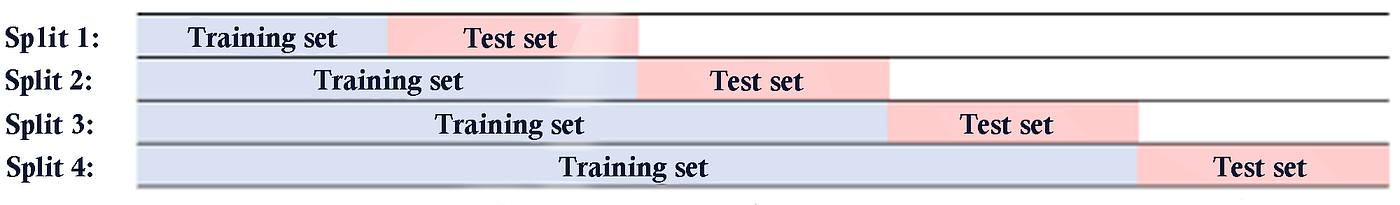

In [33]:
tscv = TimeSeriesSplit(n_splits=4)

for fold, (tr_idx, te_idx) in enumerate(tscv.split(X, y)):
    X_tr, X_te  = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te  = y.iloc[tr_idx], y.iloc[te_idx]
    
    print(f"Fold {fold}:")
    print(f"Train size: {len(y_tr)}, class ratio: {round(np.sum(y_tr == 1) / len(y_tr), 3)}")
    print(f"Test size: {len(y_te)},  class ratio: {round(np.sum(y_te == 1) / len(y_te), 3)}")

Fold 0:
Train size: 8240, class ratio: 0.031
Test size: 8237,  class ratio: 0.054
Fold 1:
Train size: 16477, class ratio: 0.043
Test size: 8237,  class ratio: 0.059
Fold 2:
Train size: 24714, class ratio: 0.048
Test size: 8237,  class ratio: 0.111
Fold 3:
Train size: 32951, class ratio: 0.064
Test size: 8237,  class ratio: 0.308


In [17]:
def cv_model_training(X, y, params, n_splits=4, random_state=42, eval_metric = 'auc'):

    aucs, precision_recall_lift_metrics = [], [], []
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for tr_idx, te_idx in tscv.split(X, y):
        X_tr, X_test  = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_test  = y.iloc[tr_idx], y.iloc[te_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, shuffle = False
        )
        
        model = LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric = eval_metric,
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
        )

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        aucs.append(roc_auc_score(y_test, y_prob))        
        precision_recall_lift_metrics.append(precision_recall_lift_at_k(y_test, y_prob))

    return aucs, precision_recall_lift_metrics

In [28]:
params_default = {
 'learning_rate': 0.05,
 'num_leaves': 100,
 'lambda_l2': 1.0,
 'max_depth': 10,
 'verbosity': -1,
 'seed': 42}

In [29]:
aucs, precision_recall_lift_metrics = cv_model_training(X, y, params_default, eval_metric = "accuracy")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's binary_logloss: 0.0939025
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's binary_logloss: 0.125062
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.146775
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.381613


In [30]:
aucs, precision_recall_lift_metrics

([0.9532103913409321,
  0.8969167261919094,
  0.782480914316508,
  0.6952851963804682],
 [{'precision_at_k': 0.433, 'recall_at_k': 0.796, 'lift_at_k': 7.971},
  {'precision_at_k': 0.429, 'recall_at_k': 0.732, 'lift_at_k': 7.33},
  {'precision_at_k': 0.44, 'recall_at_k': 0.397, 'lift_at_k': 3.973},
  {'precision_at_k': 0.65, 'recall_at_k': 0.211, 'lift_at_k': 2.108}])

In [31]:
aucs, precision_recall_lift_metrics = cv_model_training(X, y, params_default, eval_metric = "auc")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.953816	valid_0's binary_logloss: 0.137573
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.954503	valid_0's binary_logloss: 0.125664
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.885471	valid_0's binary_logloss: 0.146775
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.749182	valid_0's binary_logloss: 0.381613


In [32]:
aucs, precision_recall_lift_metrics

([0.9570696671290274,
  0.9108322565283808,
  0.782480914316508,
  0.6952851963804682],
 [{'precision_at_k': 0.443, 'recall_at_k': 0.817, 'lift_at_k': 8.172},
  {'precision_at_k': 0.428, 'recall_at_k': 0.73, 'lift_at_k': 7.309},
  {'precision_at_k': 0.44, 'recall_at_k': 0.397, 'lift_at_k': 3.973},
  {'precision_at_k': 0.65, 'recall_at_k': 0.211, 'lift_at_k': 2.108}])

## Problem 2: MovieLens (Contextual Ranking)

MovieLens, binlerce kullanıcının filmlere verdiği yıldızlı puanları (rating) ve film türlerini barındıran, öneri sistemleri dünyasının standart kabul edilen (benchmark) en popüler veri setleriden biridir.

https://grouplens.org/datasets/movielens/100k/

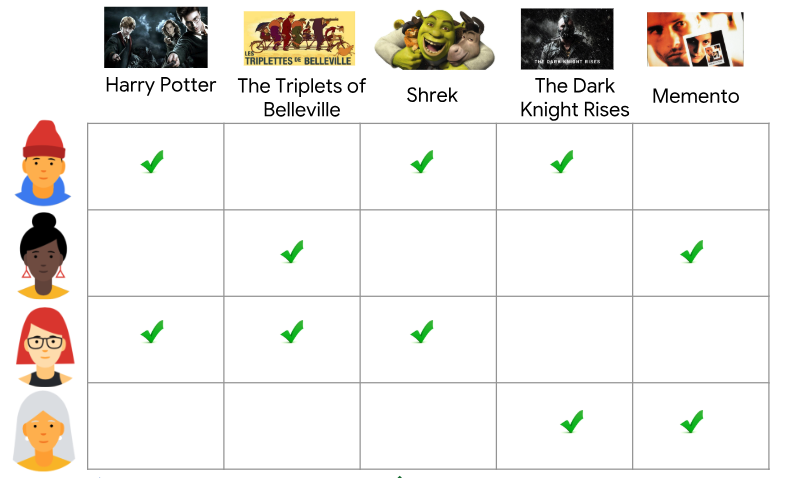

In [36]:
genre = ["Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
         "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
         "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

In [116]:
len(df)

100000

In [117]:
df.user_id.nunique()

943

In [118]:
df.movie_id.nunique()

1682

In [119]:
943 * 1682

1586126

In [111]:
# 1. Rating Verisi (Kullanıcı - Film - Puan)
ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratings['date'] = pd.to_datetime(ratings['timestamp'], unit='s')

# 2. Kullanıcı Veris(Yaş, Meslek...)
users = pd.read_csv('u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

# 3. Film Verisiu (Türler, Tarih...)
col_indices = [0, 1, 2] + list(range(5, 23))
col_names = ['movie_id', 'title', 'release_date'] + genre

movies = pd.read_csv('u.item', sep='|', encoding='latin-1', header=None, usecols=col_indices, names=col_names)

# Önce Rating ile User'ı birleştir
df = ratings.merge(users, on='user_id', how='left')

# Sonra oluşan tabloyu Movies ile birleştir
df = df.merge(movies, on='movie_id', how='left')

In [113]:
df.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'date', 'age', 'gender',
       'occupation', 'zip_code', 'title', 'release_date', 'Action',
       'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [38]:
df["release_year"] = pd.to_datetime(df["release_date"], errors='coerce').dt.year

In [39]:
df.head()

,user_id,movie_id,rating,timestamp,date,age,gender,occupation,zip_code,title,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
0,196,242,3,881250949,1997-12-04 15:55:49,49,M,writer,55105,Kolya (1996),...,0,0,0,0,0,0,0,0,0,1997.0
1,186,302,3,891717742,1998-04-04 19:22:22,39,F,executive,00000,L.A. Confidential (1997),...,0,1,0,0,1,0,0,1,0,1997.0
2,22,377,1,878887116,1997-11-07 07:18:36,25,M,writer,40206,Heavyweights (1994),...,0,0,0,0,0,0,0,0,0,1994.0
3,244,51,2,880606923,1997-11-27 05:02:03,28,M,technician,80525,Legends of the Fall (1994),...,0,0,0,0,0,1,0,0,1,1994.0
4,166,346,1,886397596,1998-02-02 05:33:16,47,M,educator,55113,Jackie Brown (1997),...,0,0,0,0,0,0,0,0,0,1997.0


In [41]:
cat_columns = ["gender", "occupation"]

In [114]:
df["target"] = df["rating"].apply(lambda x: 1 if x > 3 else 0)

In [115]:
df.target.value_counts()

target
1    55375
0    44625
Name: count, dtype: int64

In [43]:
df.groupby("occupation")[["user_id"]].count().sort_values("user_id", ascending = False)

,user_id
occupation,
student,21957
other,10663
educator,9442
engineer,8175
programmer,7801
administrator,7479
writer,5536
librarian,5273
technician,3506


In [44]:
df = df.sort_values('date').reset_index(drop=True)

In [45]:
occupations = ["student", "educator", "engineer", "programmer", "administrator", "writer", "librarian"]
df["occupation_new"] = np.where(df.occupation.isin(occupations), df["occupation"], "other")

### Feature Engineering

Çıkarılanlar:
- Kullanıcı geçmişte kaç film puanlamış, bunların kaçını beğenmiş
- Kullanıcı geçmişte o türde (genre) kaç film puanlamış, bunların kaçını beğenmiş
- Filmin geçmişte beğenilme oranı
- Geçmişte kullanıcıyla aynı meslekteki diğer kullanıcıların filmi beğenilme oranı

Öneriler:
- Yaş grubu / cinsiyete göre filmin beğenilme oranı
- Meslek / yaş grubu / cinsiyete göre göre türün beğenilme oranı
- ...

In [46]:
# 1. USER FEATURES
df['user_total_ratings'] = df.groupby('user_id').cumcount()
df['user_liked_ratings'] = df.groupby('user_id')['target'].cumsum() - df['target']

# 2. MOVIE FEATURES
df['movie_total_ratings'] = df.groupby('movie_id').cumcount()
df['movie_liked_ratings'] = df.groupby('movie_id')['target'].cumsum() - df['target']

# 3. OCCUPATION FEATURES
df['occupation_movie_total'] = df.groupby('occupation_new').cumcount()
df['occupation_movie_liked'] = df.groupby('occupation_new')['target'].cumsum() - df['target']

# 4. USER-GENRE FEATURES
user_genre_total = []
user_genre_liked = []

for g in genre:
    df[f'temp_{g}'] = df[g]
    df[f'temp_{g}_target'] = df[g] * df['target']
    
# User-genre için cumsum
df['user_genre_total'] = 0
df['user_genre_liked'] = 0

for g in genre:
    df['user_genre_total'] += df.groupby('user_id')[f'temp_{g}'].cumsum() - df[f'temp_{g}']
    df['user_genre_liked'] += df.groupby('user_id')[f'temp_{g}_target'].cumsum() - df[f'temp_{g}_target']
    df.drop([f'temp_{g}', f'temp_{g}_target'], axis=1, inplace=True)

# Rate hesapla
df['user_like_rate'] = (df['user_liked_ratings'] / df['user_total_ratings'])
df['user_genre_like_rate'] = (df['user_genre_liked'] / df['user_genre_total'])
df['movie_like_rate'] = (df['movie_liked_ratings'] / df['movie_total_ratings'])
df['occupation_like_rate'] = (df['occupation_movie_liked'] / df['occupation_movie_total'])

In [48]:
df.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'date', 'age', 'gender',
       'occupation', 'zip_code', 'title', 'release_date', 'Action',
       'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'release_year', 'target', 'occupation_new', 'user_total_ratings',
       'user_liked_ratings', 'movie_total_ratings', 'movie_liked_ratings',
       'occupation_movie_total', 'occupation_movie_liked', 'user_genre_total',
       'user_genre_liked', 'user_like_rate', 'user_genre_like_rate',
       'movie_like_rate', 'occupation_like_rate'],
      dtype='object')

In [49]:
model_columns = ['age', 'gender',
       'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'occupation_new', 'user_total_ratings', 'user_liked_ratings',
       'movie_total_ratings', 'movie_liked_ratings', 'occupation_movie_total',
       'occupation_movie_liked', 'user_genre_total', 'user_genre_liked',
       'user_like_rate', 'user_genre_like_rate', 'movie_like_rate',
       'occupation_like_rate', 'release_year']

In [51]:
# belli bir verisi olan kullanıcıları al.
df_last = df[df.user_total_ratings > 1]

In [52]:
df_last.occupation_new = df_last.occupation_new.astype("category")
df_last.gender = df_last.gender.astype("category")

/var/folders/6y/sywgn8vn4l7g1n57lv_t28s40000gn/T/ipykernel_10275/2338028567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last.occupation_new = df_last.occupation_new.astype("category")
/var/folders/6y/sywgn8vn4l7g1n57lv_t28s40000gn/T/ipykernel_10275/2338028567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last.gender = df_last.gender.astype("category")


In [53]:
df_last.user_id.nunique()

943

In [54]:
df_last.target.value_counts()

target
1    54248
0    43866
Name: count, dtype: int64

### Split

In [55]:
def train_val_test_split(df, val_percent=0.2, test_percent=0.2):
    
    unique_user_ids = df["user_id"].unique()
    np.random.seed(42)
    
    test_user_ids = np.random.choice(unique_user_ids, size=int(len(unique_user_ids) * test_percent), replace=False)
    
    remaining_user_ids = np.setdiff1d(unique_user_ids, test_user_ids)
    val_user_ids = np.random.choice(remaining_user_ids, size=int(len(unique_user_ids) * val_percent), replace=False)
    
    test = df[df["user_id"].isin(test_user_ids)]
    val = df[df["user_id"].isin(val_user_ids)]
    train = df[~df["user_id"].isin(test_user_ids) & ~df["user_id"].isin(val_user_ids)]
    
    return train, val, test

In [56]:
train, val, test = train_val_test_split(df_last, val_percent=0.2, test_percent=0.2)
train = train.sort_values(by=['user_id', 'timestamp'])
val = val.sort_values(by=['user_id', 'timestamp'])    
test = test.sort_values(by=['user_id', 'timestamp'])

In [122]:
len(train), len(val), len(test)

(59224, 20321, 18569)

In [57]:
def create_groups(train, val, test):
    q_train = train.groupby('user_id').size().to_list()
    q_test = test.groupby('user_id').size().to_list()
    q_val = val.groupby('user_id').size().to_list()

    return q_train, q_test, q_val

In [58]:
q_train, q_test, q_val = create_groups(train, val, test)

### Evalutaion Metric:

#### NDCG (Normalized Discounted Cumulative Gain) Score:

NDCG, önerilen öğelerin sadece ilgili olup olmadığına değil, aynı zamanda ne kadar ilgili olduğuna (relevance score) ve listenin neresinde sunulduğuna (position) bakan gelişmiş bir metriktir. Özellikle en alakalı sonucun en tepede olmasının kritik olduğu arama motorları ve öneri sistemlerinde model başarısını ölçmek için kullanılır.

https://towardsdatascience.com/demystifying-ndcg-bee3be58cfe0/

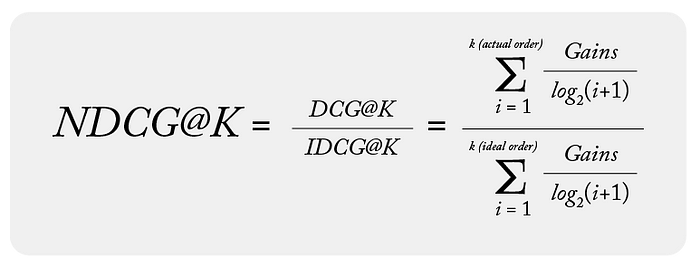

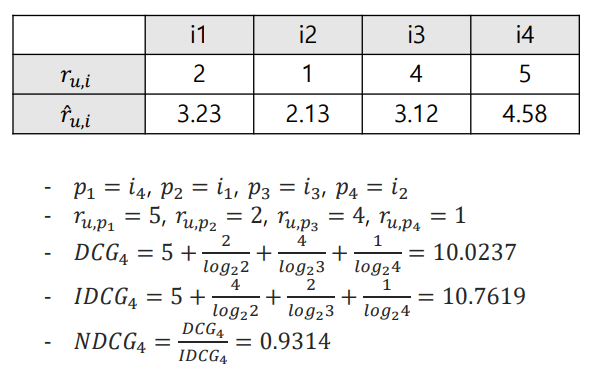

In [83]:
def ndcg_evaluation(test_df, y_pred, query_list, k):
    
    y_true = test_df["target"].values
    
    indices = np.cumsum([0] + query_list)
    
    true_splits = [y_true[indices[i]:indices[i+1]] for i in range(len(indices)-1)]
    pred_splits = [y_pred[indices[i]:indices[i+1]] for i in range(len(indices)-1)]
    
    max_len = max(query_list) 
    
    padded_true = [np.pad(row, (0, max_len - len(row)), constant_values=0.0) for row in true_splits]
    padded_pred = [np.pad(row, (0, max_len - len(row)), constant_values=-100.0) for row in pred_splits]
    
    return ndcg_score(padded_true, padded_pred, k=k)

### Modelling

In [98]:
def model_training(
    train, test, val, q_train, q_test, q_val, params, model_columns = model_columns,
    eval_metric='auc', k = 5
):

    model = LGBMClassifier(
        metric=eval_metric,
        random_state=42,
        **params
    )

    model.fit(
        X=train[model_columns],
        y=train["target"],
        eval_set=[(val[model_columns], val["target"])],
        eval_metric=eval_metric,
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
    )

    y_val_prob = model.predict_proba(val[model_columns])[:, 1] 
    y_test_prob = model.predict_proba(test[model_columns])[:, 1] 

    auc_val = roc_auc_score(val["target"], y_val_prob)
    auc_test = roc_auc_score(test["target"], y_test_prob)

    ndcg_val = ndcg_evaluation(val, model.predict_proba(val[model_columns])[:, 1], q_val, k)
    ndcg_test = ndcg_evaluation(test, model.predict_proba(test[model_columns])[:, 1], q_test, k)

    print(f"AUC val: {auc_val:.3f}, AUC test: {auc_test:.3f}")
    print(f"NDCG val: {ndcg_val:.3f}, NDCG test: {ndcg_test:.3f}")

    return model

In [95]:
def model_training_ranking(
    train, test, val, q_train, q_test, q_val, params, model_columns = model_columns,
    eval_metric='ndcg', k = 5
):

    model = lgb.LGBMRanker(
        objective="lambdarank",
        metric=eval_metric,
        random_state=42,
        **params
    )

    model.fit(
        X=train[model_columns],
        y=train["target"],
        group=q_train,
        eval_set=[(val[model_columns], val["target"])],
        eval_group=[q_val],
        eval_metric=eval_metric,
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
    )

    y_val_prob = model.predict(val[model_columns])
    y_test_prob = model.predict(test[model_columns]) 

    auc_val = roc_auc_score(val["target"], y_val_prob)
    auc_test = roc_auc_score(test["target"], y_test_prob)
    
    ndcg_val = ndcg_evaluation(val, model.predict(val[model_columns]), q_val, k)
    ndcg_test = ndcg_evaluation(test, model.predict(test[model_columns]), q_test, k)

    print(f"AUC val: {auc_val:.3f}, AUC test: {auc_test:.3f}")
    print(f"NDCG val: {ndcg_val:.3f}, NDCG test: {ndcg_test:.3f}")

    return model

In [62]:
params_default = {
 'learning_rate': 0.05,
 'num_leaves': 150,
 'lambda_l2': 1.0,
 'max_depth': 10,
 'verbosity': -1,
 'seed': 42}

In [99]:
model = model_training(train, test, val, q_train, q_test, q_val, params_default)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.748541
AUC val: 0.749, AUC test: 0.756
NDCG val: 0.777, NDCG test: 0.753


In [97]:
model_ranking = model_training_ranking(train, test, val, q_train, q_test, q_val, params_default)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's ndcg@1: 0.851064	valid_0's ndcg@2: 0.842833	valid_0's ndcg@3: 0.851005	valid_0's ndcg@4: 0.83134	valid_0's ndcg@5: 0.819272
AUC val: 0.679, AUC test: 0.676
NDCG val: 0.820, NDCG test: 0.764


### Bakılacaklar:

- Feature engineering yaparak farklı feature lar türetmeye çalışın. Bu feature'ların model performansına etkisine bakın.
- Feature importance analizi yapın.

- Farklı evaluation metrikler ile modelde parameter tuning yaparak evaluation metriklerini inceleyin
  - 1. problem için auc gibi classification metrikleriyle tune edip precision@k, recall@k, lift@k metriklerini gözlemleyin.
  - 2. problem için NDCG dışında MAP, MRR gibi ranking metriklerini gözlemleyin.